# 1. Import and Install Dependencies

In [1]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [2]:
#!pip install -q tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [3]:
# !wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/kcmpdxky7p-1.zip

In [4]:
# !unzip -q /content/kcmpdxky7p-1.zip

In [5]:
# !7z x /content/ISL_CSLRT_Corpus.zip

In [5]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [6]:
#!pip install opencv-python

In [7]:
# !pip install mediapipe 
# !pip install sklearn 
# !pip install matplotlib

# 2. Keypoints using MP Holistic

In [8]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [9]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [10]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [11]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [12]:
#%% (2) Model definition.
import tensorflow.compat.v1 as tf

class GRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float32):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=dtype, shape=(None, None, input_dimensions), name='input')
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=dtype, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        z_t = tf.sigmoid((tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz))*r_t + self.bz)
        
        # Definition of h~_t
        h_proposal = tf.nn.elu(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t

In [13]:
#%% (3) Initialize and train the model.
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
session = tf.Session()

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reverved for the second term
input_dimensions = 1662 #features
classes=13
batch_size =50
hidden_size = 32
time_size = 30 #window size
lr = 1e-3
epochs = 101
# Initialize a session

# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float32, shape=(hidden_size*time_size, classes), mean=0, stddev=0.05))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float32, shape=(classes,), mean=0, stddev=0.05))
output = tf.map_fn(lambda h_t: tf.nn.softsign(tf.matmul(tf.reshape(h_t,(1,hidden_size*time_size)), W_output) + b_output), gru.h_t)
output = tf.reshape(output,((batch_size, classes)))
# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float32, shape=(batch_size, classes), name='expected_output')

# Just use quadratic loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(expected_output,output))
print(expected_output,W_output,b_output,output,loss)
accs = tf.reduce_mean(tf.metrics.accuracy(labels=tf.argmax(expected_output, axis=1), predictions=tf.argmax(output,axis=1))) 
# loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)

# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Initialize all the variables
init_variables = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

session.run(init_variables)
session.run(init_l)


Tensor("expected_output:0", shape=(50, 13), dtype=float32) <tf.Variable 'Variable:0' shape=(960, 13) dtype=float32> <tf.Variable 'Variable_1:0' shape=(13,) dtype=float32> Tensor("Reshape:0", shape=(50, 13), dtype=float32) Tensor("Mean:0", shape=(), dtype=float32)


In [14]:
tf.compat.v1.disable_eager_execution()

saver = tf.compat.v1.train.Saver()
saved_path ='gru/gru-219' #saved model
with tf.compat.v1.Session() as sess:
    saver.restore(sess, saved_path)

INFO:tensorflow:Restoring parameters from gru/gru-219


In [15]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [16]:
import pickle 
import time
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output

le = pickle.load(open('labelencoder.pkl','rb')) #saved label encoder
#cap = cv2.VideoCapture('/content/ISL_CSLRT_Corpus/Videos_Sentence_Level/thank you so much/thank you so much (1).MP4')
cap = cv2.VideoCapture(0)

# Set mediapipe model 
window=time_size #defined above

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    count=0
    frames=[]
    while cap.isOpened():
        count+=1
        # Read feed
        ret, frame = cap.read()

        # Make detections
        if ret==True:
            start = time.time()
            image, results = mediapipe_detection(frame, holistic)
            print(results)
            pose = []
            for res in results.pose_landmarks.landmark:
                test = np.array([res.x, res.y, res.z, res.visibility])
                pose.append(test)
            pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
            face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
            lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
            rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
            result_test = extract_keypoints(results)
            frames.append(result_test)
            if len(frames)>=window:
                # Make a prediction by using the model
                test_input = np.expand_dims(np.array(frames[-window:]),axis=0)
                print(test_input.shape)
                y_predicted = session.run(output, feed_dict={gru.input_layer: test_input})
                y_predicted_confidence = np.max(y_predicted)
                y_predicted = np.argmax(y_predicted,axis=-1)
                action = le.inverse_transform(y_predicted)
                print('\nPredictions: \n',y_predicted,"\nConfidence: ",y_predicted_confidence)
                print("Inference Time: ",time.time()-start)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                cv2.putText(image, 'Frame Number {}'.format(count), (15,45), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(image, 'Action: {} '.format(action), (image.shape[0]//2,45), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 1, cv2.LINE_AA)
                clear_output(wait=True)

                # Show to screen
                cv2.imshow('frame',image)
                time.sleep(0.01)
                frames = frames[-(window-1):]
            else:
                continue
        else: 
            break
        # Break gracefully
    cap.release()
    cv2.destroyAllWindows()

C:\Users\Lab\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [17]:
cap.release()
cv2.destroyAllWindows()

In [18]:
draw_landmarks(frame, results)

NameError: name 'frame' is not defined

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# 3. Extract Keypoint Values

In [19]:
#len(results.left_hand_landmarks.landmark)

In [20]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)


NameError: name 'results' is not defined

In [21]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


NameError: name 'results' is not defined

In [22]:
#face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
    #if results.face_landmarks 
   #else np.zeros(1404)


In [23]:
result_test = extract_keypoints(results)


NameError: name 'results' is not defined

In [24]:
result_test.shape

NameError: name 'result_test' is not defined

In [25]:
result_test=result_test.reshape(1,result_test.shape[0],1)
result_test.shape


NameError: name 'result_test' is not defined

In [26]:
# Make a prediction by using the model
import pickle 
le = pickle.load(open('C:/Users/Lab/Desktop/Barathi/ActionDetectionforSignLanguage/GRU modified/GRU/labelencoder.pkl','rb'))
y_predicted = session.run(output, feed_dict={gru.input_layer: result_test})
y_predicted_confidence = np.max(y_predicted)
y_predicted = np.argmax(y_predicted,axis=-1)
print(y_predicted)

print('\nPredictions: \n',le.inverse_transform(y_predicted),"\nConfidence: ",y_predicted_confidence)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Lab/Desktop/Barathi/ActionDetectionforSignLanguage/GRU modified/GRU/labelencoder.pkl'

In [27]:
np.save('0', result_test)

NameError: name 'result_test' is not defined

In [28]:
np.load('0.npy')

array([[[ 0.48671284],
        [ 0.49158585],
        [-0.8947469 ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]])

# 4. Setup Folders for Collection

In [29]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello','thankyou','takecare','good','fail','like','friend','think','phonecall','meet','you','iloveyou','location'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
#start_folder = 30

In [30]:
for action in actions: 
   # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [31]:
actions

array(['hello', 'thankyou', 'takecare', 'good', 'fail', 'like', 'friend',
       'think', 'phonecall', 'meet', 'you', 'iloveyou', 'location'],
      dtype='<U9')

# 5. Collect Keypoint Values for Training and Testing

In [32]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # NEW LOOP
#     # Loop through actions
#     for action in actions:
#         # Loop through sequences aka videos
#         for sequence in range(no_sequences):
#             # Loop through video length aka sequence length
#             for frame_num in range(sequence_length):

#                 # Read feed
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)
#                 print(results)
#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 # NEW Apply wait logic
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(500)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
                
#                 # NEW Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints)
                
#                 cv2.imshow('opencv feed' ,image)

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    
#     cap.release()
#     cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [33]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [34]:
label_map = {label:num for num, label in enumerate(actions)}

In [35]:
label_map

{'hello': 0,
 'thankyou': 1,
 'takecare': 2,
 'good': 3,
 'fail': 4,
 'like': 5,
 'friend': 6,
 'think': 7,
 'phonecall': 8,
 'meet': 9,
 'you': 10,
 'iloveyou': 11,
 'location': 12}

In [36]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [37]:
np.array(sequences).shape

(390, 30, 1662)

In [38]:
np.array(labels).shape

(390,)

In [39]:
X = np.array(sequences)

In [40]:
X.shape

(390, 30, 1662)

In [41]:
y = to_categorical(labels).astype(int)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [43]:
y_test.shape

(20, 13)

In [44]:
X.shape

(390, 30, 1662)

In [45]:
# 7. Build and Train LSTM Neural Network

# Standard GRU

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [47]:
log_dir = os.path.join('LogsGRU')
tb_callback = TensorBoard(log_dir=log_dir)

In [48]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(GRU(32, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [50]:
history_1 = model.fit(X_train, y_train, epochs=100, validation_split=0.2,callbacks=[tb_callback])

Train on 296 samples, validate on 74 samples
Epoch 1/100
288/296 [============================>.] - ETA: 0s - loss: 2.8344 - categorical_accuracy: 0.0451

C:\Users\Lab\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


296/296 [==============================] - 2s 6ms/sample - loss: 2.8320 - categorical_accuracy: 0.0439 - val_loss: 2.5470 - val_categorical_accuracy: 0.0541
Epoch 2/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.6800 - categorical_accuracy: 0.0777 - val_loss: 2.5090 - val_categorical_accuracy: 0.1081
Epoch 3/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.6699 - categorical_accuracy: 0.0912 - val_loss: 2.5080 - val_categorical_accuracy: 0.1081
Epoch 4/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.6064 - categorical_accuracy: 0.0743 - val_loss: 2.4951 - val_categorical_accuracy: 0.0811
Epoch 5/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.4817 - categorical_accuracy: 0.1182 - val_loss: 2.4486 - val_categorical_accuracy: 0.1622
Epoch 6/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.3568 - categorical_accuracy: 0.1858 - val_loss: 2.4290 - val_categorical_accuracy: 0.175

296/296 [==============================] - 1s 2ms/sample - loss: 0.4933 - categorical_accuracy: 0.8176 - val_loss: 1.3402 - val_categorical_accuracy: 0.5270
Epoch 50/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.6035 - categorical_accuracy: 0.7973 - val_loss: 0.7412 - val_categorical_accuracy: 0.6892
Epoch 51/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.5662 - categorical_accuracy: 0.8209 - val_loss: 1.7512 - val_categorical_accuracy: 0.3919
Epoch 52/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4896 - categorical_accuracy: 0.8547 - val_loss: 1.6928 - val_categorical_accuracy: 0.4189
Epoch 53/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4981 - categorical_accuracy: 0.8412 - val_loss: 0.8363 - val_categorical_accuracy: 0.7027
Epoch 54/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4346 - categorical_accuracy: 0.8682 - val_loss: 0.6754 - val_categorical_accuracy: 

296/296 [==============================] - 1s 2ms/sample - loss: 0.2181 - categorical_accuracy: 0.9358 - val_loss: 0.7653 - val_categorical_accuracy: 0.7297
Epoch 98/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.1875 - categorical_accuracy: 0.9493 - val_loss: 0.6955 - val_categorical_accuracy: 0.7703
Epoch 99/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.2136 - categorical_accuracy: 0.9291 - val_loss: 0.7891 - val_categorical_accuracy: 0.7838
Epoch 100/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.2503 - categorical_accuracy: 0.9122 - val_loss: 1.0515 - val_categorical_accuracy: 0.7162


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           688128    
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 64)            37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                2

In [52]:
history_1.history

{'loss': [2.8319912021224565,
  2.680028296805717,
  2.6699312828682564,
  2.606444874325314,
  2.4817476788082637,
  2.35680243453464,
  2.288707836254223,
  2.25253811398068,
  2.197579148653391,
  2.1252618287060714,
  2.0417692532410494,
  1.995962432912878,
  1.8890718253883156,
  1.8514452012809548,
  1.780344801980096,
  1.7526377632811263,
  1.739275262162492,
  1.6158200695707992,
  1.5537635377935461,
  1.5257009589994275,
  1.4686123873736407,
  1.4474642212326463,
  1.4048836650075138,
  1.3693715978313137,
  1.2250192133156028,
  1.2102324962615967,
  1.1995395035357088,
  1.1754875022011835,
  1.054587013012654,
  0.9646709674113506,
  0.9867893747381262,
  0.9663326611389985,
  0.9241894580222465,
  0.7732800438597396,
  0.8268504400511045,
  0.9118692166096455,
  1.0365709871859163,
  0.915214441918038,
  0.8756281298560065,
  0.7668909962112839,
  0.6860363644522589,
  0.6793362498283386,
  0.5985292937304523,
  0.5731230209002623,
  0.5170408688686989,
  0.54352687097

# 8. Make Predictions

In [53]:
res = model.predict(X_test)

In [54]:
actions[np.argmax(res[1])]

'phonecall'

In [55]:
actions[np.argmax(y_test[1])]

'like'

# 9. Save Weights

In [56]:
model.save('actionGRU.h5')

In [57]:
#model.load_weights('actionGRU.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [58]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,classification_report

In [59]:
yhat = model.predict(X_test)

In [60]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [61]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[19,  0],
        [ 0,  1]],

       [[15,  2],
        [ 0,  3]],

       [[15,  5],
        [ 0,  0]],

       [[17,  0],
        [ 1,  2]],

       [[18,  0],
        [ 1,  1]],

       [[17,  1],
        [ 0,  2]],

       [[16,  0],
        [ 4,  0]],

       [[19,  0],
        [ 0,  1]],

       [[16,  0],
        [ 2,  2]]], dtype=int64)

In [62]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytrue, yhat)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

NameError: name 'metrics' is not defined

In [63]:
accuracy_score(ytrue, yhat)

0.6

In [64]:
from sklearn import metrics

In [65]:
print(f"Classification report for Sign Gestures \n"
      f"{metrics.classification_report(ytrue, yhat)}\n")

Classification report for Sign Gestures 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.60      1.00      0.75         3
           3       0.00      0.00      0.00         0
           5       1.00      0.67      0.80         3
           6       1.00      0.50      0.67         2
           8       0.67      1.00      0.80         2
           9       0.00      0.00      0.00         4
          10       1.00      1.00      1.00         1
          12       1.00      0.50      0.67         4

    accuracy                           0.60        20
   macro avg       0.70      0.63      0.63        20
weighted avg       0.71      0.60      0.61        20




C:\Users\Lab\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lab\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


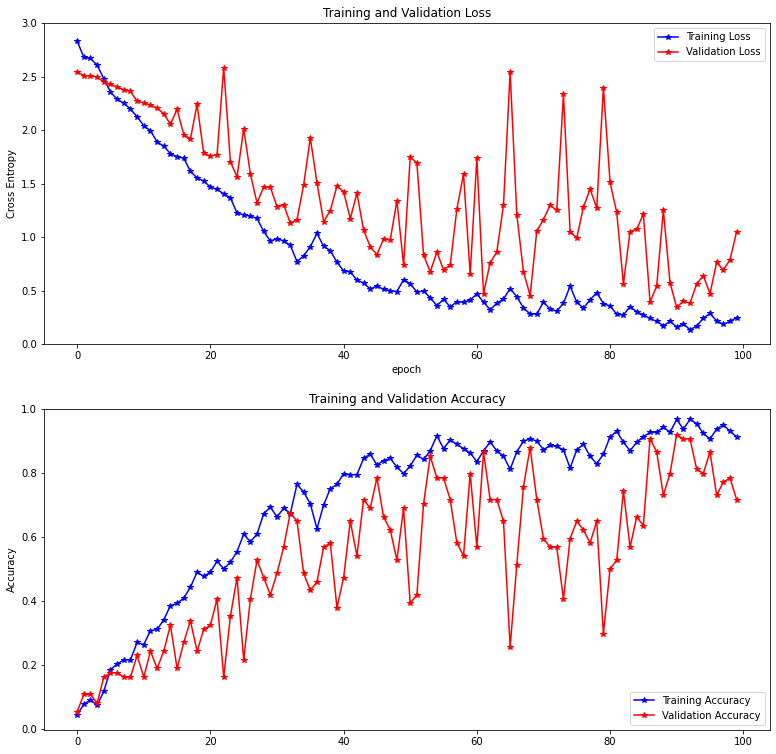

In [66]:
acc = history_1.history['categorical_accuracy']
val_acc = history_1.history['val_categorical_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']


plt.figure(figsize=(13, 13))
plt.subplot(2, 1, 2)
plt.plot(acc,'-b*', label='Training Accuracy')
plt.plot(val_acc,'-r*', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss,'-b*', label='Training Loss')
plt.plot(val_loss,'-r*', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()




In [67]:
from sklearn.metrics import r2_score

In [68]:
r2_score(ytrue, yhat)

-0.3557046979865772

In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
mean_squared_error(ytrue, yhat)

20.2

In [71]:
from sklearn.metrics import mean_absolute_error

In [72]:
mean_absolute_error(ytrue, yhat)

2.6

In [73]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: [1.8083442449569702, 0.6]


# 11. Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245),(245,117,16), (117,245,16), (16,117,245),(245,117,16), (117,245,16), (16,117,245),(245,117,16), (117,245,16), (16,117,245),(245,117,16)]
# def prob_viz(res, actions, input_frame, colors):
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res):
#         cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
#     return output_frame

In [ ]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Evaluation with LSTM

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [75]:
log_dir = os.path.join('Logs2_LSTM')
tb_callback = TensorBoard(log_dir=log_dir)

In [76]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='elu', input_shape=(30,1662)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [77]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
history_2 = model.fit(X_train, y_train, epochs=100, validation_split=0.2,callbacks=[tb_callback])
#_, accuracy = model.evaluate(X_test, y_test,epochs=100, validation_split=0.2,callbacks=[tb_callback])

In [ ]:
model.summary()

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])]

In [ ]:
actions[np.argmax(y_test[1])]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,classification_report

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
from sklearn import metrics

In [ ]:
print(f"Classification report for Sign Gestures \n"
      f"{metrics.classification_report(ytrue, yhat)}\n")

In [ ]:
acc = history_2.history['categorical_accuracy']
val_acc = history_2.history['val_categorical_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(13, 13))
plt.subplot(2, 1, 2)
plt.plot(acc,'-b*', label='Training Accuracy')
plt.plot(val_acc,'-r*', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss,'-b*', label='Training Loss')
plt.plot(val_loss,'-r*', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()




In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(ytrue, yhat)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Evaluation with SimpleRNN

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [79]:
log_dir = os.path.join('Logs3_RNN')
tb_callback = TensorBoard(log_dir=log_dir)

In [80]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, activation='elu', input_shape=(30,1662)))
model.add(Dropout(0.2))
model.add(SimpleRNN(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(SimpleRNN(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [81]:
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [82]:
history_3 = model.fit(X_train, y_train, epochs=100, validation_split=0.2,callbacks=[tb_callback])

Train on 296 samples, validate on 74 samples
Epoch 1/100
288/296 [============================>.] - ETA: 0s - loss: 2.8613 - categorical_accuracy: 0.0590

C:\Users\Lab\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


296/296 [==============================] - 1s 4ms/sample - loss: 2.8649 - categorical_accuracy: 0.0608 - val_loss: 2.5884 - val_categorical_accuracy: 0.1081
Epoch 2/100
296/296 [==============================] - 0s 947us/sample - loss: 2.8256 - categorical_accuracy: 0.0541 - val_loss: 2.5606 - val_categorical_accuracy: 0.1081
Epoch 3/100
296/296 [==============================] - 0s 1ms/sample - loss: 2.7841 - categorical_accuracy: 0.0811 - val_loss: 2.5566 - val_categorical_accuracy: 0.1216
Epoch 4/100
296/296 [==============================] - 0s 1ms/sample - loss: 2.8122 - categorical_accuracy: 0.0608 - val_loss: 2.5373 - val_categorical_accuracy: 0.1757
Epoch 5/100
296/296 [==============================] - 0s 1ms/sample - loss: 2.7509 - categorical_accuracy: 0.1081 - val_loss: 2.5454 - val_categorical_accuracy: 0.1757
Epoch 6/100
296/296 [==============================] - 0s 960us/sample - loss: 2.7119 - categorical_accuracy: 0.0811 - val_loss: 2.5383 - val_categorical_accuracy: 0

Epoch 49/100
296/296 [==============================] - 0s 910us/sample - loss: 2.4733 - categorical_accuracy: 0.1351 - val_loss: 2.5668 - val_categorical_accuracy: 0.1081
Epoch 50/100
296/296 [==============================] - 0s 902us/sample - loss: 2.4442 - categorical_accuracy: 0.1588 - val_loss: 2.4406 - val_categorical_accuracy: 0.1216
Epoch 51/100
296/296 [==============================] - 0s 924us/sample - loss: 2.4497 - categorical_accuracy: 0.1655 - val_loss: 2.3874 - val_categorical_accuracy: 0.1216
Epoch 52/100
296/296 [==============================] - 0s 961us/sample - loss: 2.3951 - categorical_accuracy: 0.1655 - val_loss: 2.3840 - val_categorical_accuracy: 0.1351
Epoch 53/100
296/296 [==============================] - 0s 952us/sample - loss: 2.3845 - categorical_accuracy: 0.1486 - val_loss: 2.4618 - val_categorical_accuracy: 0.1081
Epoch 54/100
296/296 [==============================] - 0s 823us/sample - loss: 2.3549 - categorical_accuracy: 0.1622 - val_loss: 2.3660 - v

296/296 [==============================] - 0s 866us/sample - loss: 1.7642 - categorical_accuracy: 0.4088 - val_loss: 2.0054 - val_categorical_accuracy: 0.2703
Epoch 97/100
296/296 [==============================] - 0s 857us/sample - loss: 1.9528 - categorical_accuracy: 0.3041 - val_loss: 2.1006 - val_categorical_accuracy: 0.2838
Epoch 98/100
296/296 [==============================] - 0s 924us/sample - loss: 1.7618 - categorical_accuracy: 0.4257 - val_loss: 1.9170 - val_categorical_accuracy: 0.3243
Epoch 99/100
296/296 [==============================] - 0s 883us/sample - loss: 1.7114 - categorical_accuracy: 0.4257 - val_loss: 1.8860 - val_categorical_accuracy: 0.2838
Epoch 100/100
296/296 [==============================] - 0s 941us/sample - loss: 1.6520 - categorical_accuracy: 0.4831 - val_loss: 1.8474 - val_categorical_accuracy: 0.3108


In [83]:
history_3.history

{'loss': [2.8649343413275643,
  2.8256148905367464,
  2.784143222344888,
  2.812221823511897,
  2.7509244519311027,
  2.7119285222646354,
  2.699510580784566,
  2.694979513013685,
  2.7187961823231466,
  2.6702898064175167,
  2.7413526096859493,
  2.6761708001832702,
  2.7087771183735616,
  2.6686848305367135,
  2.6830808407551534,
  2.7285058820569836,
  2.6242677198873983,
  2.6454541232134843,
  2.6633217012560046,
  2.6226674994906864,
  2.6534770372751595,
  2.61745073988631,
  2.6248415998510413,
  2.663811683654785,
  2.631010377729261,
  2.6193261275420316,
  2.6108668559306376,
  2.6266309119559623,
  2.6742993560997217,
  2.6581589853441394,
  2.645473441562137,
  2.659733868934013,
  2.596216839713019,
  2.6205506840267696,
  2.61725969572325,
  2.6258984578622355,
  2.587065464741475,
  2.610760495469377,
  2.5657644400725492,
  2.6000920179727913,
  2.5596380362639555,
  2.529786651198928,
  2.5511145849485657,
  2.5326127490481816,
  2.477036353704092,
  2.506875076809445

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 64)            110528    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30, 128)           24704     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

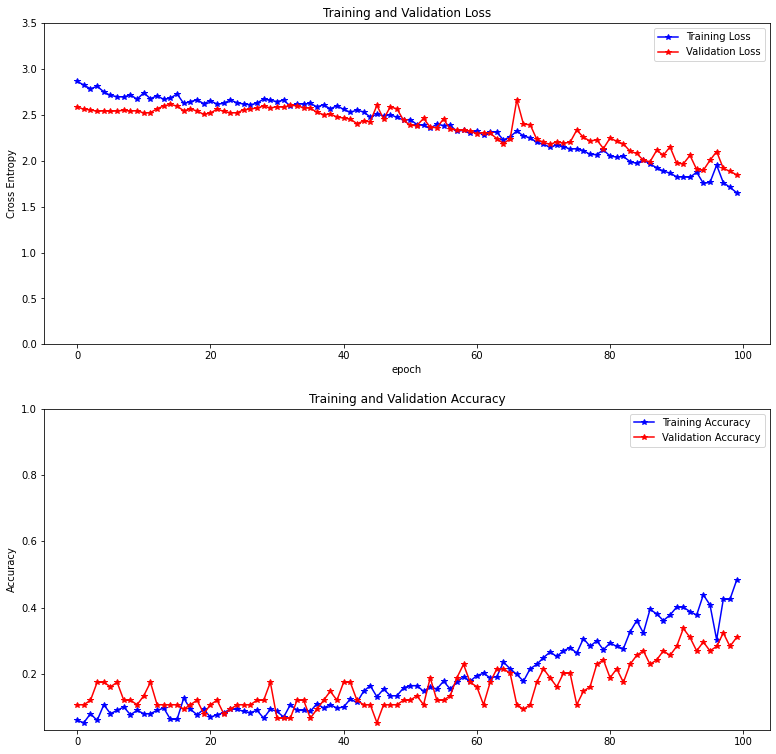

In [85]:
acc = history_3.history['categorical_accuracy']
val_acc = history_3.history['val_categorical_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(13, 13))
plt.subplot(2, 1, 2)
plt.plot(acc,'-b*', label='Training Accuracy')
plt.plot(val_acc,'-r*', label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss,'-b*', label='Training Loss')
plt.plot(val_loss,'-r*', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()




In [86]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: [1.6742655038833618, 0.3]


In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])]

In [ ]:
actions[np.argmax(y_test[1])]

In [ ]:
from sklearn import metrics

In [ ]:
print(f"Classification report for Sign Gestures \n"
      f"{metrics.classification_report(ytrue, yhat)}\n")

In [ ]:
metrics.accuracy_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(ytrue, yhat)

# Proposed GRU

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [88]:
log_dir = os.path.join('LogsMGRU')
tb_callback = TensorBoard(log_dir=log_dir)

In [89]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='elu', input_shape=(30,1662)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(GRU(32, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [90]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [91]:
history_4 = model.fit(X_train, y_train, epochs=100, validation_split=0.2,callbacks=[tb_callback])

Train on 296 samples, validate on 74 samples
Epoch 1/100
296/296 [==============================] - 2s 6ms/sample - loss: 2.6748 - categorical_accuracy: 0.0709 - val_loss: 2.6160 - val_categorical_accuracy: 0.0541
Epoch 2/100
296/296 [==============================] - 1s 3ms/sample - loss: 2.6417 - categorical_accuracy: 0.0946 - val_loss: 2.6208 - val_categorical_accuracy: 0.0541
Epoch 3/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.4766 - categorical_accuracy: 0.1419 - val_loss: 2.5463 - val_categorical_accuracy: 0.0270
Epoch 4/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.4569 - categorical_accuracy: 0.1318 - val_loss: 2.5318 - val_categorical_accuracy: 0.0676
Epoch 5/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.4372 - categorical_accuracy: 0.1318 - val_loss: 2.5950 - val_categorical_accuracy: 0.0541
Epoch 6/100
296/296 [==============================] - 1s 2ms/sample - loss: 2.3529 - categorical_accuracy: 0.

Epoch 49/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4482 - categorical_accuracy: 0.8818 - val_loss: 1.6867 - val_categorical_accuracy: 0.4054
Epoch 50/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4739 - categorical_accuracy: 0.8615 - val_loss: 1.1506 - val_categorical_accuracy: 0.6757
Epoch 51/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4611 - categorical_accuracy: 0.8615 - val_loss: 1.0177 - val_categorical_accuracy: 0.6351
Epoch 52/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4301 - categorical_accuracy: 0.9054 - val_loss: 0.9308 - val_categorical_accuracy: 0.6081
Epoch 53/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.4394 - categorical_accuracy: 0.8682 - val_loss: 0.9004 - val_categorical_accuracy: 0.6216
Epoch 54/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.3375 - categorical_accuracy: 0.9257 - val_loss: 1.0411 - val_categoric

296/296 [==============================] - 1s 2ms/sample - loss: 0.4678 - categorical_accuracy: 0.8412 - val_loss: 1.6547 - val_categorical_accuracy: 0.5541
Epoch 98/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.2586 - categorical_accuracy: 0.9189 - val_loss: 1.7557 - val_categorical_accuracy: 0.5405
Epoch 99/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.2155 - categorical_accuracy: 0.9358 - val_loss: 0.4892 - val_categorical_accuracy: 0.8378
Epoch 100/100
296/296 [==============================] - 1s 2ms/sample - loss: 0.1431 - categorical_accuracy: 0.9595 - val_loss: 0.6664 - val_categorical_accuracy: 0.8378


In [92]:
history_4.history

{'loss': [2.6747680097012907,
  2.6416647369797164,
  2.4766075482239596,
  2.4568717544143266,
  2.4372136850614807,
  2.352927659008954,
  2.256331372905422,
  2.2256045921428784,
  2.2358944609358504,
  2.2021385527945854,
  2.1647307904990942,
  2.0951339650798486,
  2.026395604417131,
  2.035210477339255,
  1.9252502724931047,
  1.9195648399559226,
  1.914584069638639,
  1.8297051287986137,
  1.7271397983705676,
  1.6683658039247669,
  1.5869583890244767,
  1.5772738940006978,
  1.6551643803312972,
  1.5957483633144482,
  1.50372314453125,
  1.5456344888016984,
  1.3547378456270374,
  1.3756168565234623,
  1.239095781300519,
  1.329566641433819,
  1.0488241524309725,
  1.0674481842968915,
  0.9825795921119483,
  0.9026162431046769,
  0.8427150764980832,
  1.0237647778279073,
  0.9036545044667011,
  0.829806798213237,
  0.8549978894156378,
  0.7877507354762103,
  0.8214124795552846,
  0.6491272256181047,
  0.6945983864165641,
  0.7197788116094228,
  0.6125443497219601,
  0.58196792

In [ ]:
model.summary()

In [ ]:
acc = history_4.history['categorical_accuracy']
val_acc = history_4.history['val_categorical_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 2)
plt.plot(acc,'-b*', label='Training Accuracy')
plt.plot(val_acc,'-r*', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss,'-b*', label='Training Loss')
plt.plot(val_loss,'-r*', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()




In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])] 

In [ ]:
actions[np.argmax(y_test[1])]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,classification_report

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
from sklearn import metrics

In [ ]:
print(f"Classification report for Sign Gestures \n"
      f"{metrics.classification_report(ytrue, yhat)}\n")

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(ytrue, yhat)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Bidirectional GRU

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import TensorBoard

In [94]:
model = Sequential()
model.add(Bidirectional(GRU(64, return_sequences=True, activation='elu', input_shape=(30,1662))))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(64, return_sequences=False, activation='relu')))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [95]:
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [96]:
history_5 = model.fit(X_train, y_train, epochs=100, validation_split=0.2,callbacks=[tb_callback])

Train on 296 samples, validate on 74 samples
Epoch 1/100
296/296 [==============================] - 2s 8ms/sample - loss: 2.6806 - categorical_accuracy: 0.0574 - val_loss: 2.6045 - val_categorical_accuracy: 0.0541
Epoch 2/100
296/296 [==============================] - 1s 3ms/sample - loss: 2.5647 - categorical_accuracy: 0.1284 - val_loss: 2.5859 - val_categorical_accuracy: 0.0541
Epoch 3/100
296/296 [==============================] - 1s 3ms/sample - loss: 2.4964 - categorical_accuracy: 0.1351 - val_loss: 2.5458 - val_categorical_accuracy: 0.0541
Epoch 4/100
296/296 [==============================] - 1s 3ms/sample - loss: 2.4228 - categorical_accuracy: 0.1689 - val_loss: 2.5135 - val_categorical_accuracy: 0.1216
Epoch 5/100
296/296 [==============================] - 1s 3ms/sample - loss: 2.2956 - categorical_accuracy: 0.2095 - val_loss: 2.4703 - val_categorical_accuracy: 0.1216
Epoch 6/100
296/296 [==============================] - 1s 3ms/sample - loss: 2.2073 - categorical_accuracy: 0.

Epoch 49/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.4190 - categorical_accuracy: 0.9493 - val_loss: 0.6102 - val_categorical_accuracy: 0.8649
Epoch 50/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.3950 - categorical_accuracy: 0.9426 - val_loss: 0.5666 - val_categorical_accuracy: 0.9054
Epoch 51/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.3736 - categorical_accuracy: 0.9392 - val_loss: 0.5980 - val_categorical_accuracy: 0.8784
Epoch 52/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.3857 - categorical_accuracy: 0.9358 - val_loss: 0.6138 - val_categorical_accuracy: 0.8243
Epoch 53/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.3636 - categorical_accuracy: 0.9493 - val_loss: 0.6256 - val_categorical_accuracy: 0.8243
Epoch 54/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.3386 - categorical_accuracy: 0.9426 - val_loss: 0.5850 - val_categoric

296/296 [==============================] - 1s 3ms/sample - loss: 0.1263 - categorical_accuracy: 0.9764 - val_loss: 0.6813 - val_categorical_accuracy: 0.7973
Epoch 98/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.1328 - categorical_accuracy: 0.9696 - val_loss: 0.4276 - val_categorical_accuracy: 0.8784
Epoch 99/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.1199 - categorical_accuracy: 0.9831 - val_loss: 0.2663 - val_categorical_accuracy: 0.9189
Epoch 100/100
296/296 [==============================] - 1s 3ms/sample - loss: 0.0988 - categorical_accuracy: 0.9797 - val_loss: 0.3486 - val_categorical_accuracy: 0.9324


In [97]:
history_5.history

{'loss': [2.6805590938877417,
  2.5646938762149296,
  2.496377674308983,
  2.422804252521412,
  2.2956418282276876,
  2.207306868321187,
  2.212847239262349,
  2.1709406955822095,
  2.075830685125815,
  1.9766772437740017,
  1.8638490180711489,
  1.791139309470718,
  1.7076491987383045,
  1.6547691757614549,
  1.5830388326902647,
  1.5864390618092306,
  1.4951299783345815,
  1.4410280601398364,
  1.3936384304149732,
  1.2992122688808956,
  1.2621604107521676,
  1.2283678699184108,
  1.1783147438152417,
  1.1173299776541221,
  1.0455779707109607,
  1.0351377435632654,
  1.002691607217531,
  0.9753486981263032,
  0.9090425420451809,
  0.8384009406373307,
  0.8467428507031621,
  0.8194812632895805,
  0.7822775776321823,
  0.744510293006897,
  0.7192024733569171,
  0.7063216728133124,
  0.765172494424356,
  0.6788731732883969,
  0.6137772266929215,
  0.5481380788055626,
  0.5727031424238875,
  0.5664484436447556,
  0.5682880878448486,
  0.5085910752012923,
  0.4652134824443508,
  0.4604456

In [98]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  663552    
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  198144    
_________________________________________________________________
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  123648    
_________________________________________________________________
dense_12 (Dense)             multiple                  8256      
_________________________________________________________________
batch_normalization_4 (Batch multiple                 

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])] 

In [ ]:
actions[np.argmax(y_test[1])]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,classification_report

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
from sklearn import metrics

In [ ]:
print(f"Classification report for Sign Gestures \n"
      f"{metrics.classification_report(ytrue, yhat)}\n")

In [ ]:
acc = history_5.history['categorical_accuracy']
val_acc = history_5.history['val_categorical_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']


plt.figure(figsize=(13, 13))
plt.subplot(2, 1, 2)
plt.plot(acc,'-b*', label='Training Accuracy')
plt.plot(val_acc,'-r*', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss,'-b*', label='Training Loss')
plt.plot(val_loss,'-r*', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(ytrue, yhat)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Bidirectional LSTM

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import TensorBoard

In [100]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='elu', input_shape=(30,1662))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False, activation='relu')))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [101]:
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [102]:
history_6 = model.fit(X_train, y_train, epochs=100, validation_split=0.2,callbacks=[tb_callback])

Train on 296 samples, validate on 74 samples
Epoch 1/100
296/296 [==============================] - 3s 10ms/sample - loss: 2.7307 - categorical_accuracy: 0.1149 - val_loss: 2.6168 - val_categorical_accuracy: 0.0946
Epoch 2/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.7683 - categorical_accuracy: 0.0642 - val_loss: 2.6282 - val_categorical_accuracy: 0.0811
Epoch 3/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.6704 - categorical_accuracy: 0.0777 - val_loss: 2.6242 - val_categorical_accuracy: 0.0541
Epoch 4/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.6627 - categorical_accuracy: 0.0912 - val_loss: 2.6116 - val_categorical_accuracy: 0.0946
Epoch 5/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.6556 - categorical_accuracy: 0.0709 - val_loss: 2.5578 - val_categorical_accuracy: 0.1081
Epoch 6/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.5927 - categorical_accuracy: 0

Epoch 49/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.1124 - categorical_accuracy: 0.2399 - val_loss: 2.3427 - val_categorical_accuracy: 0.2162
Epoch 50/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.0831 - categorical_accuracy: 0.2331 - val_loss: 2.2842 - val_categorical_accuracy: 0.2297
Epoch 51/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.0833 - categorical_accuracy: 0.2568 - val_loss: 2.2262 - val_categorical_accuracy: 0.2432
Epoch 52/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.0632 - categorical_accuracy: 0.2669 - val_loss: 2.1883 - val_categorical_accuracy: 0.2297
Epoch 53/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.0621 - categorical_accuracy: 0.2466 - val_loss: 2.3104 - val_categorical_accuracy: 0.2027
Epoch 54/100
296/296 [==============================] - 1s 4ms/sample - loss: 2.0501 - categorical_accuracy: 0.2770 - val_loss: 2.1966 - val_categoric

296/296 [==============================] - 1s 4ms/sample - loss: 1.6494 - categorical_accuracy: 0.3919 - val_loss: 1.5897 - val_categorical_accuracy: 0.3514
Epoch 98/100
296/296 [==============================] - 1s 4ms/sample - loss: 1.5796 - categorical_accuracy: 0.4595 - val_loss: 1.8335 - val_categorical_accuracy: 0.4324
Epoch 99/100
296/296 [==============================] - 1s 4ms/sample - loss: 1.5696 - categorical_accuracy: 0.4257 - val_loss: 1.6588 - val_categorical_accuracy: 0.4324
Epoch 100/100
296/296 [==============================] - 1s 4ms/sample - loss: 1.5759 - categorical_accuracy: 0.4561 - val_loss: 1.9161 - val_categorical_accuracy: 0.3919


In [103]:
history_6.history

{'loss': [2.7307004928588867,
  2.7682837537817053,
  2.6704329026711955,
  2.662742704958529,
  2.6556100587587097,
  2.592652011562038,
  2.6213828486365243,
  2.516540649774912,
  2.458447604566007,
  2.463040222992768,
  2.4313103637179814,
  2.4234931662275985,
  2.380459450386666,
  2.3563394804258606,
  2.33681092391143,
  2.3545692933572306,
  2.3555395538742476,
  2.377469539642334,
  2.3424486082953377,
  2.289692144136171,
  2.3159949070698507,
  2.2994123085125073,
  2.2990167656460323,
  2.274926862201175,
  2.300880238816545,
  2.2851962269963444,
  2.260740563676164,
  2.2332688408928947,
  2.2704033336123906,
  2.3018627166748047,
  2.257869952433818,
  2.2818727493286133,
  2.2436765400139063,
  2.27209455902512,
  2.292335523141397,
  2.2380819449553617,
  2.232401519208341,
  2.1814191792462325,
  2.2271387254869617,
  2.214349836916537,
  2.167809396176725,
  2.1907239153578475,
  2.156961131740261,
  2.182093723400219,
  2.1393699194933915,
  2.119533841674392,
  2

In [104]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection multiple                  884224    
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
bidirectional_4 (Bidirection multiple                  263168    
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  164352    
_________________________________________________________________
dense_15 (Dense)             multiple                  8256      
_________________________________________________________________
batch_normalization_5 (Batch multiple                 

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])] 

In [ ]:
actions[np.argmax(y_test[1])]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,classification_report

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
from sklearn import metrics

In [ ]:
print(f"Classification report for Sign Gestures \n"
      f"{metrics.classification_report(ytrue, yhat)}\n")

In [ ]:
acc = history_6.history['categorical_accuracy']
val_acc = history_6.history['val_categorical_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']


plt.figure(figsize=(13, 13))
plt.subplot(2, 1, 2)
plt.plot(acc,'-b*', label='Training Accuracy')
plt.plot(val_acc,'-r*', label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss,'-b*', label='Training Loss')
plt.plot(val_loss,'-r*', label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(ytrue, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(ytrue, yhat)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

In [105]:
import matplotlib.pyplot as plt


In [106]:
%matplotlib inline

NameError: name 'history_2' is not defined

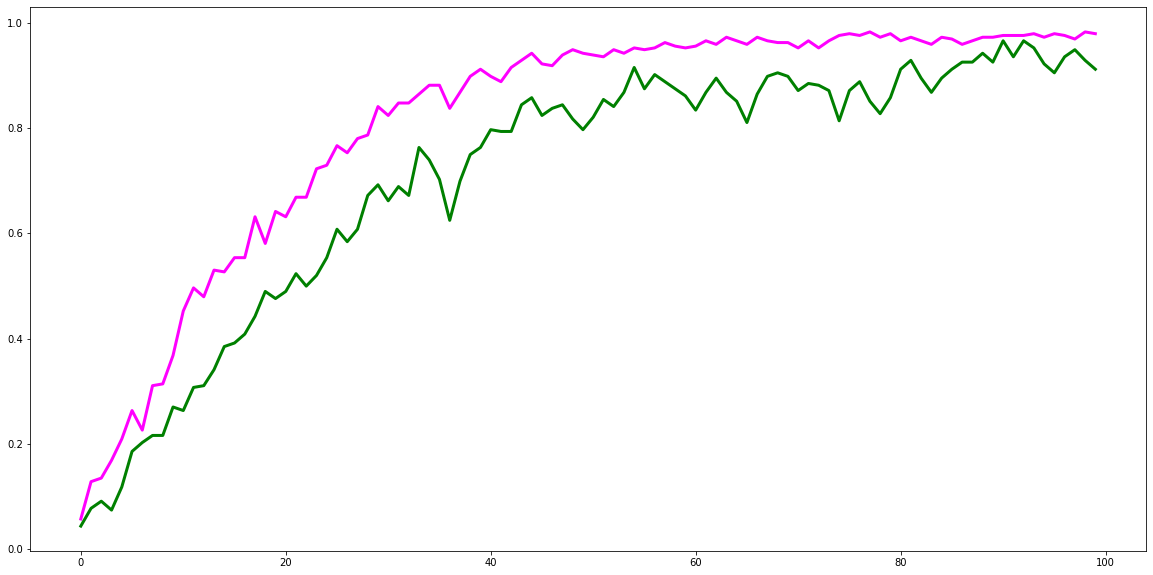

In [107]:
plt.figure(figsize=(20, 10))
x5 = history_5.history['categorical_accuracy']
plt.plot(x5,color="magenta",linewidth=3,label="Pose-OGRU")
x1 = history_1.history['categorical_accuracy']
plt.plot(x1,color="g",linewidth=3,label="Standard GRU")
x2 = history_2.history['categorical_accuracy']
plt.plot(x2,color="r",linewidth=3,label="LSTM")
x3 = history_3.history['categorical_accuracy']
plt.plot(x3,linewidth=3,label="RNN")
plt.xlabel('Epoch',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.ylabel('Accuracy',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
#plt.title('Training Accuracy',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.legend(loc="best",shadow=True,prop={'size': 20})
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
x5 = history_5.history['loss']
plt.plot(x5,color="magenta",linewidth=3,label="Pose-OGRU")
x1 = history_1.history['loss']
plt.plot(x1,color="g",linewidth=3,label="Standard GRU")
x2 = history_6.history['loss']
plt.plot(x2,color="r",linewidth=3,label="LSTM")
x3 = history_3.history['loss']
plt.plot(x3,linewidth=3,label="RNN")
plt.xlabel('Epoch',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.ylabel('Loss',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
#plt.title('Training Loss',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.legend(loc="best",shadow=True,prop={'size': 20})
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
x5 = history_5.history['val_categorical_accuracy']
plt.plot(x5,color="magenta",linewidth=3,label="Pose-OGRU")
x1 = history_1.history['val_categorical_accuracy']
plt.plot(x1,color="g",linewidth=3,label="Standard GRU")
x2 = history_6.history['val_categorical_accuracy']
plt.plot(x2,color="r",linewidth=3,label="LSTM")
x3 = history_3.history['val_categorical_accuracy']
plt.plot(x3,linewidth=3,label="RNN")
plt.xlabel('Epoch',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.ylabel('Accuracy',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
#plt.title('Validation Accuracy',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.legend(loc="best",shadow=True,prop={'size': 20})
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
x5 = history_5.history['val_loss']
plt.plot(x5,color="magenta",linewidth=3,label="Pose-OGRU")
x1 = history_1.history['val_loss']
plt.plot(x1,color="g",linewidth=3,label="Standard GRU")
x2 = history_6.history['val_loss']
plt.plot(x2,color="r",linewidth=3,label="LSTM")
x3 = history_3.history['val_loss']
plt.plot(x3,linewidth=3,label="RNN")
plt.xlabel('Epoch',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.ylabel('Loss',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
#plt.title('Validation Loss',fontdict={'fontname':'Times New Roman', 'fontsize':25,'weight': 'bold'})
plt.legend(loc="best",shadow=True,prop={'size': 20})
plt.grid(True)
plt.show()